In [1]:
# -*- coding: utf-8 -*-
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#    http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or
# implied.
# See the License for the specific language governing permissions and
# limitations under the License.
#

# Time-series forecasting with Deep Learning
Modified script based on [How to use Keras TimeseriesGenerator for time series data](https://www.dlology.com/blog/how-to-use-keras-timeseriesgenerator-for-time-series-data/)

#### Instalation
`mpld3` enables zooming of the matplotlib and interactive data visualizations on Jupyter notebook.

Install it with `pip install mpld3`

Also `pip install pydot`

In [2]:
import mpld3
mpld3.enable_notebook()

In [30]:
import numpy as np
import pandas as pd

from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

from sklearn.preprocessing import MinMaxScaler, PowerTransformer, QuantileTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

import math
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')
plt.rcParams["figure.figsize"] = (6,4.5)

import seaborn as sns
sns.set(context='paper', style='whitegrid', color_codes=True)   
sns.set_palette(sns.color_palette(["#017b92", "#f97306", "#ff0000"]))  # ["green", "orange", "red"] 

#### Functions definitions

In [4]:
# get all targets y from a TimeseriesGenerator instance.
def get_y_from_generator(gen):
    y = None
    for i in range(len(gen)):
        batch_y = gen[i][1]
        if y is None:
            y = batch_y
        else:
            y = np.append(y, batch_y)
    y = y.reshape((-1,1))
    print(y.shape)
    return y

# compute the match score of two binary numpy arrays.
def binary_accuracy(a, b):
    assert len(a) == len(b)
    return (a == b).sum() / len(a)    

#### Load data
DJI, AAPL, AMAZN close index/price during 2015/09/19-2018/09/18
- URL [YAHOO finance](https://finance.yahoo.com/quote/AMZN/history?period1=1442592000&period2=1537286400&interval=1d&filter=history&frequency=1d).

(756, 1)


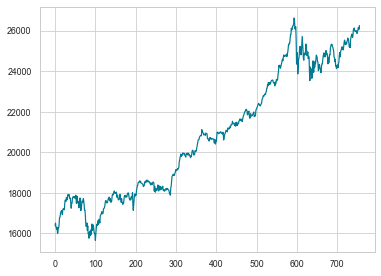

In [31]:
dataset_DJI = pd.read_csv('./data/DJI_20150919-20180918.csv', usecols=[4]).values.astype('float32')
dataset = dataset_DJI
print(dataset.shape)
plt.plot(dataset_DJI)


## Single time series as input
#### Data normalization

In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

#### Data splitting and transformation

In [7]:
train_size = int(len(dataset) * 0.70)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

look_back = 10
train_data_gen = TimeseriesGenerator(train, 
                                     train,
                                     length=look_back, 
                                     sampling_rate=1,
                                     stride=1,
                                     batch_size=1
                                    )
test_data_gen = TimeseriesGenerator(test, 
                                    test,
                                    length=look_back, 
                                    sampling_rate=1,
                                    stride=1,
                                    batch_size=1
                                   )

#### Training

In [8]:
x = Input(shape=(look_back, 1))
h = LSTM(units=200)(x)
y = Dense(units=1, activation='sigmoid')(h)
model = Model(inputs=x, outputs=y)
print(model.summary())

# compile model
opt = Adam(learning_rate=0.001)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mse', 'mae'])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10, 1)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 200)               161600    
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
None


In [9]:
model.fit(train_data_gen, epochs=100)

Epoch 1/100
519/519 [==============================] - 3s 3ms/step - loss: 0.0130 - mse: 0.0130 - mae: 0.0752
Epoch 2/100
519/519 [==============================] - 2s 3ms/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0294
Epoch 3/100
519/519 [==============================] - 2s 3ms/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0296
Epoch 4/100
519/519 [==============================] - 2s 3ms/step - loss: 9.7437e-04 - mse: 9.7437e-04 - mae: 0.0239
Epoch 5/100
519/519 [==============================] - 2s 3ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0292
Epoch 6/100
519/519 [==============================] - 2s 3ms/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0238
Epoch 7/100
519/519 [==============================] - 2s 3ms/step - loss: 7.3999e-04 - mse: 7.3999e-04 - mae: 0.0212
Epoch 8/100
519/519 [==============================] - 2s 3ms/step - loss: 9.2114e-04 - mse: 9.2114e-04 - mae: 0.0237
Epoch 9/100
519/519 [==============================] - 2s 3ms/step - loss: 8.1347e-04 - mse: 8.1

519/519 [==============================] - 2s 4ms/step - loss: 1.5380e-04 - mse: 1.5380e-04 - mae: 0.0092
Epoch 71/100
519/519 [==============================] - 2s 3ms/step - loss: 1.8992e-04 - mse: 1.8992e-04 - mae: 0.0100
Epoch 72/100
519/519 [==============================] - 2s 3ms/step - loss: 1.7707e-04 - mse: 1.7707e-04 - mae: 0.0094
Epoch 73/100
519/519 [==============================] - 2s 3ms/step - loss: 1.5194e-04 - mse: 1.5194e-04 - mae: 0.0090
Epoch 74/100
519/519 [==============================] - 2s 3ms/step - loss: 1.4114e-04 - mse: 1.4114e-04 - mae: 0.0089
Epoch 75/100
519/519 [==============================] - 2s 3ms/step - loss: 1.7806e-04 - mse: 1.7806e-04 - mae: 0.0101
Epoch 76/100
519/519 [==============================] - 2s 3ms/step - loss: 1.4247e-04 - mse: 1.4247e-04 - mae: 0.0089
Epoch 77/100
519/519 [==============================] - 2s 3ms/step - loss: 1.6139e-04 - mse: 1.6139e-04 - mae: 0.0092
Epoch 78/100
519/519 [==============================] - 2s 3m

In [10]:
model.evaluate(test_data_gen)

217/217 [==============================] - 1s 1ms/step - loss: 0.0021 - mse: 0.0021 - mae: 0.0390  


[0.0021271861623972654, 0.0021271861623972654, 0.039008140563964844]

In [11]:
trainPredict = model.predict(train_data_gen)
trainPredict.shape

(519, 1)

In [12]:
testPredict = model.predict(test_data_gen)
testPredict.shape

(217, 1)

#### Invert transformation

In [13]:
trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)

In [14]:
trainY = get_y_from_generator(train_data_gen)
testY = get_y_from_generator(test_data_gen)

(519, 1)
(217, 1)


In [15]:
trainY = scaler.inverse_transform(trainY)
testY = scaler.inverse_transform(testY)

#### Model evaluation

In [16]:
# RMSE
trainScore = math.sqrt(mean_squared_error(trainY[:,0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[:, 0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 134.99 RMSE
Test Score: 505.33 RMSE


#### Plotting

In [22]:
begin = train_size + look_back
end = begin + len(testPredict)

testYPlot = np.empty_like(dataset_DJI)
testYPlot[:, :] = np.nan
testYPlot[begin:end, :] = testY

testPredictPlot = np.empty_like(dataset_DJI)
testPredictPlot[:, :] = np.nan
testPredictPlot[begin:end, :] = testPredict

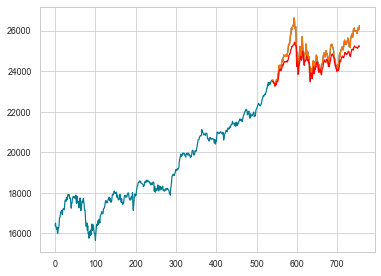

In [32]:
# plot baseline and predictions
plt.plot(dataset_DJI)
plt.plot(testYPlot)
plt.plot(testPredictPlot)
plt.show()